In [26]:
# Install required packages if not already installed
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Required packages
required_packages = [
    "pdfplumber",
    "pandas",
    "matplotlib",
    "seaborn"
]

for package in required_packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed")


✓ pdfplumber already installed
✓ pandas already installed
✓ matplotlib already installed
✓ seaborn already installed


In [27]:
# Import required libraries
import re
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
import datetime as dt
import csv

# Set matplotlib to display Hungarian characters properly
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial Unicode MS', 'Segoe UI']

print("All libraries imported successfully!")


All libraries imported successfully!


In [28]:
# Configuration
PDF_PATH = Path("../mav/2024-2025._evi_belfoldi_kozforgalmu_menetrend_06.21_-_12.13-ig_v06.25.pdf")

# Check if PDF exists
if PDF_PATH.exists():
    print(f"✓ PDF found: {PDF_PATH}")
    print(f"File size: {PDF_PATH.stat().st_size / (1024*1024):.1f} MB")
else:
    print(f"❌ PDF not found at: {PDF_PATH}")
    print("Please check the file path and try again.")


✓ PDF found: ..\mav\2024-2025._evi_belfoldi_kozforgalmu_menetrend_06.21_-_12.13-ig_v06.25.pdf
File size: 3.7 MB


In [29]:
def extract_route_pairs_from_pdf(pdf_path, max_pages=10, debug=True):
    """
    Extract station pairs from MÁV PDF by parsing route headers correctly.
    
    Args:
        pdf_path: Path to the PDF file
        max_pages: Maximum number of pages to process (use None for all pages)
        debug: Whether to show debug information
    
    Returns:
        List of dictionaries with route information
    """
    
    if debug:
        print(f"🔍 Starting extraction from: {pdf_path}")
        if max_pages:
            print(f"📄 Processing first {max_pages} pages for testing")
        else:
            print(f"📄 Processing ALL pages")
    
    all_routes = []
    
    with pdfplumber.open(pdf_path) as pdf:
        total_pages = len(pdf.pages)
        pages_to_process = pdf.pages[:max_pages] if max_pages else pdf.pages
        
        if debug:
            print(f"📖 Total pages in PDF: {total_pages}")
            print(f"🔄 Will process: {len(pages_to_process)} pages")
        
        for i, page in enumerate(pages_to_process, 1):
            try:
                text = page.extract_text()
                if not text:
                    continue
                
                lines = [line.strip() for line in text.splitlines() if line.strip()]
                
                # Find route headers with em-dash or en-dash
                for line in lines:
                    if ('—' in line or '–' in line) and re.search(r'\d+', line):
                        
                        if debug and i <= 3:  # Show debug for first 3 pages
                            print(f"\n🔍 Page {i}, Found route header: '{line}'")
                        
                        # Parse the route header
                        clean_header = line.replace('—', '|').replace('–', '|')
                        parts = [part.strip() for part in clean_header.split('|') if part.strip()]
                        
                        if len(parts) >= 2:
                            # Remove leading numbers from first part
                            first_part = re.sub(r'^\d+\s+', '', parts[0]).strip()
                            last_part = parts[-1].strip()
                            
                            # Extract just the city names (Hungarian characters supported)
                            start_match = re.search(r'^([A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+(?:\s+[A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+)*)', first_part)
                            end_match = re.search(r'^([A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+(?:\s+[A-Za-záéíóöőúüűÁÉÍÓÖŐÚÜŰ]+)*)', last_part)
                            
                            if start_match and end_match:
                                start = start_match.group(1).strip()
                                end = end_match.group(1).strip()
                                
                                # Only keep if both stations are valid and different
                                if start and end and start != end and len(start) > 2 and len(end) > 2:
                                    route_info = {
                                        'page': i,
                                        'route_header': line,
                                        'source': start,
                                        'destination': end,
                                        'total_stations': len(parts),
                                        'intermediate_stations': parts[1:-1] if len(parts) > 2 else []
                                    }
                                    all_routes.append(route_info)
                                    
                                    if debug and i <= 3:
                                        print(f"   ✅ Extracted: {start} → {end} ({len(parts)} stations)")
            
            except Exception as e:
                if debug:
                    print(f"   ⚠️  Error on page {i}: {e}")
                continue
    
    if debug:
        print(f"\n🎯 EXTRACTION COMPLETE!")
        print(f"   📊 Total routes found: {len(all_routes)}")
        print(f"   📄 Pages with routes: {len(set(r['page'] for r in all_routes))}")
        
        if all_routes:
            print(f"\n📋 SAMPLE RESULTS:")
            for i, route in enumerate(all_routes[:5], 1):
                print(f"   {i}. {route['source']} → {route['destination']} (Page {route['page']})")
    
    return all_routes

# Test extraction on first 5 pages
print("🧪 TESTING EXTRACTION ON FIRST 5 PAGES")
print("="*50)
test_routes = extract_route_pairs_from_pdf(PDF_PATH, max_pages=5, debug=True)


🧪 TESTING EXTRACTION ON FIRST 5 PAGES
🔍 Starting extraction from: ..\mav\2024-2025._evi_belfoldi_kozforgalmu_menetrend_06.21_-_12.13-ig_v06.25.pdf
📄 Processing first 5 pages for testing
📖 Total pages in PDF: 724
🔄 Will process: 5 pages

🔍 Page 2, Found route header: '1 Budapest — Hegyeshalom — Rajka'
   ✅ Extracted: Budapest → Rajka (3 stations)

🎯 EXTRACTION COMPLETE!
   📊 Total routes found: 2
   📄 Pages with routes: 2

📋 SAMPLE RESULTS:
   1. Budapest → Rajka (Page 2)
   2. Budapest → Rajka (Page 4)


In [30]:
def validate_extraction_results(routes):
    """
    Validate the quality of extracted route data.
    
    Args:
        routes: List of route dictionaries
    
    Returns:
        dict: Validation results and statistics
    """
    
    print("🧪 VALIDATING EXTRACTION RESULTS")
    print("="*40)
    
    if not routes:
        print("❌ No routes found - extraction failed")
        return {'valid': False, 'reason': 'No data'}
    
    # Basic statistics
    total_routes = len(routes)
    unique_pairs = len(set((r['source'], r['destination']) for r in routes))
    unique_sources = len(set(r['source'] for r in routes))
    unique_destinations = len(set(r['destination'] for r in routes))
    pages_with_data = len(set(r['page'] for r in routes))
    
    print(f"📊 BASIC STATISTICS:")
    print(f"   - Total routes: {total_routes}")
    print(f"   - Unique pairs: {unique_pairs}")
    print(f"   - Unique sources: {unique_sources}")
    print(f"   - Unique destinations: {unique_destinations}")
    print(f"   - Pages with data: {pages_with_data}")
    
    # Check for Hungarian cities
    major_cities = ['Budapest', 'Debrecen', 'Szeged', 'Miskolc', 'Pécs', 'Győr', 'Nyíregyháza', 'Kecskemét']
    cities_found = []
    
    for city in major_cities:
        count = sum(1 for r in routes if city.lower() in r['source'].lower() or city.lower() in r['destination'].lower())
        if count > 0:
            cities_found.append((city, count))
    
    print(f"\n🏙️  MAJOR HUNGARIAN CITIES FOUND:")
    for city, count in sorted(cities_found, key=lambda x: x[1], reverse=True):
        print(f"   - {city}: {count} routes")
    
    # Check for route quality
    print(f"\n🔍 QUALITY CHECKS:")
    
    # Check for very short names (potential errors)
    short_names = [r for r in routes if len(r['source']) < 3 or len(r['destination']) < 3]
    if short_names:
        print(f"   ⚠️  {len(short_names)} routes with very short station names")
    else:
        print(f"   ✅ No suspiciously short station names")
    
    # Check for self-loops
    self_loops = [r for r in routes if r['source'] == r['destination']]
    if self_loops:
        print(f"   ⚠️  {len(self_loops)} self-loop routes")
    else:
        print(f"   ✅ No self-loop routes")
    
    # Check for Hungarian characters
    hungarian_chars = [r for r in routes if re.search(r'[áéíóöőúüűÁÉÍÓÖŐÚÜŰ]', r['source'] + r['destination'])]
    if hungarian_chars:
        print(f"   ✅ {len(hungarian_chars)} routes with Hungarian characters")
    else:
        print(f"   ⚠️  No Hungarian characters found")
    
    # Sample validation
    print(f"\n📋 SAMPLE ROUTES FOR MANUAL VALIDATION:")
    sample_routes = routes[:10] if len(routes) >= 10 else routes
    for i, route in enumerate(sample_routes, 1):
        print(f"   {i:2d}. {route['source']} → {route['destination']} (Page {route['page']}, {route['total_stations']} stations)")
    
    # Validation scoring
    score = 0
    max_score = 6
    
    if total_routes > 10: score += 1
    if unique_pairs > 5: score += 1
    if len(cities_found) >= 3: score += 1
    if len(short_names) == 0: score += 1
    if len(self_loops) == 0: score += 1
    if len(hungarian_chars) > 0: score += 1
    
    print(f"\n🎯 VALIDATION SCORE: {score}/{max_score}")
    
    if score >= 5:
        print("✅ EXCELLENT - Extraction quality is very good!")
        valid = True
    elif score >= 3:
        print("✅ GOOD - Extraction quality is acceptable")
        valid = True
    else:
        print("❌ POOR - Extraction needs improvement")
        valid = False
    
    return {
        'valid': valid,
        'score': score,
        'max_score': max_score,
        'total_routes': total_routes,
        'unique_pairs': unique_pairs,
        'cities_found': len(cities_found),
        'quality_issues': len(short_names) + len(self_loops)
    }

# Validate the test results
validation_result = validate_extraction_results(test_routes)

if validation_result['valid']:
    print(f"\n🎉 TEST VALIDATION PASSED!")
    print(f"Ready to proceed with full extraction.")
else:
    print(f"\n⚠️  TEST VALIDATION FAILED!")
    print(f"Need to fix extraction before proceeding.")


🧪 VALIDATING EXTRACTION RESULTS
📊 BASIC STATISTICS:
   - Total routes: 2
   - Unique pairs: 1
   - Unique sources: 1
   - Unique destinations: 1
   - Pages with data: 2

🏙️  MAJOR HUNGARIAN CITIES FOUND:
   - Budapest: 2 routes

🔍 QUALITY CHECKS:
   ✅ No suspiciously short station names
   ✅ No self-loop routes
   ⚠️  No Hungarian characters found

📋 SAMPLE ROUTES FOR MANUAL VALIDATION:
    1. Budapest → Rajka (Page 2, 3 stations)
    2. Budapest → Rajka (Page 4, 3 stations)

🎯 VALIDATION SCORE: 2/6
❌ POOR - Extraction needs improvement

⚠️  TEST VALIDATION FAILED!
Need to fix extraction before proceeding.


In [31]:
def run_full_extraction():
    """
    Run extraction on all pages with progress tracking.
    Only runs if test validation passed.
    """
    
    if not validation_result['valid']:
        print("❌ Cannot run full extraction - test validation failed")
        return []
    
    print("\n🚀 STARTING FULL EXTRACTION ON ALL PAGES")
    print("="*50)
    print("⚠️  This will process all 724 pages and may take 5-10 minutes.")
    
    import time
    start_time = time.time()
    
    # Extract from all pages (max_pages=None means all pages)
    all_routes = extract_route_pairs_from_pdf(PDF_PATH, max_pages=None, debug=False)
    
    end_time = time.time()
    processing_time = end_time - start_time
    
    print(f"\n✅ FULL EXTRACTION COMPLETED!")
    print(f"   ⏱️  Processing time: {processing_time:.1f} seconds")
    print(f"   📊 Routes extracted: {len(all_routes)}")
    print(f"   📄 Pages with data: {len(set(r['page'] for r in all_routes))}")
    print(f"   📈 Processing rate: {724/processing_time:.1f} pages/second")
    
    # Quick quality check on full results
    if all_routes:
        unique_pairs = len(set((r['source'], r['destination']) for r in all_routes))
        print(f"   🎯 Unique station pairs: {unique_pairs}")
        
        print(f"\n📋 SAMPLE FROM FULL EXTRACTION:")
        for i, route in enumerate(all_routes[:10], 1):
            print(f"   {i:2d}. {route['source']} → {route['destination']} (Page {route['page']})")
    
    return all_routes

# Run full extraction if validation passed
if validation_result['valid']:
    print("\n🎯 VALIDATION PASSED - PROCEEDING WITH FULL EXTRACTION")
    full_routes = run_full_extraction()
else:
    print("\n⚠️  Skipping full extraction due to validation failure")
    print("Please check the test results and fix any issues.")
    full_routes = test_routes  # Use test data for remaining analysis



⚠️  Skipping full extraction due to validation failure
Please check the test results and fix any issues.


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo


📈 ANALYZING 2 ROUTES
📊 SUMMARY STATISTICS:
   - Total routes: 2
   - Unique station pairs: 1
   - Unique source stations: 1
   - Unique destination stations: 1
   - Pages with data: 2
   - Average stations per route: 3.0

🚉 TOP 10 SOURCE STATIONS:
    1. Budapest: 2 routes

🎯 TOP 10 DESTINATION STATIONS:
    1. Rajka: 2 routes

🚂 ROUTE LENGTH DISTRIBUTION:
   3 stations: 2 routes


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo

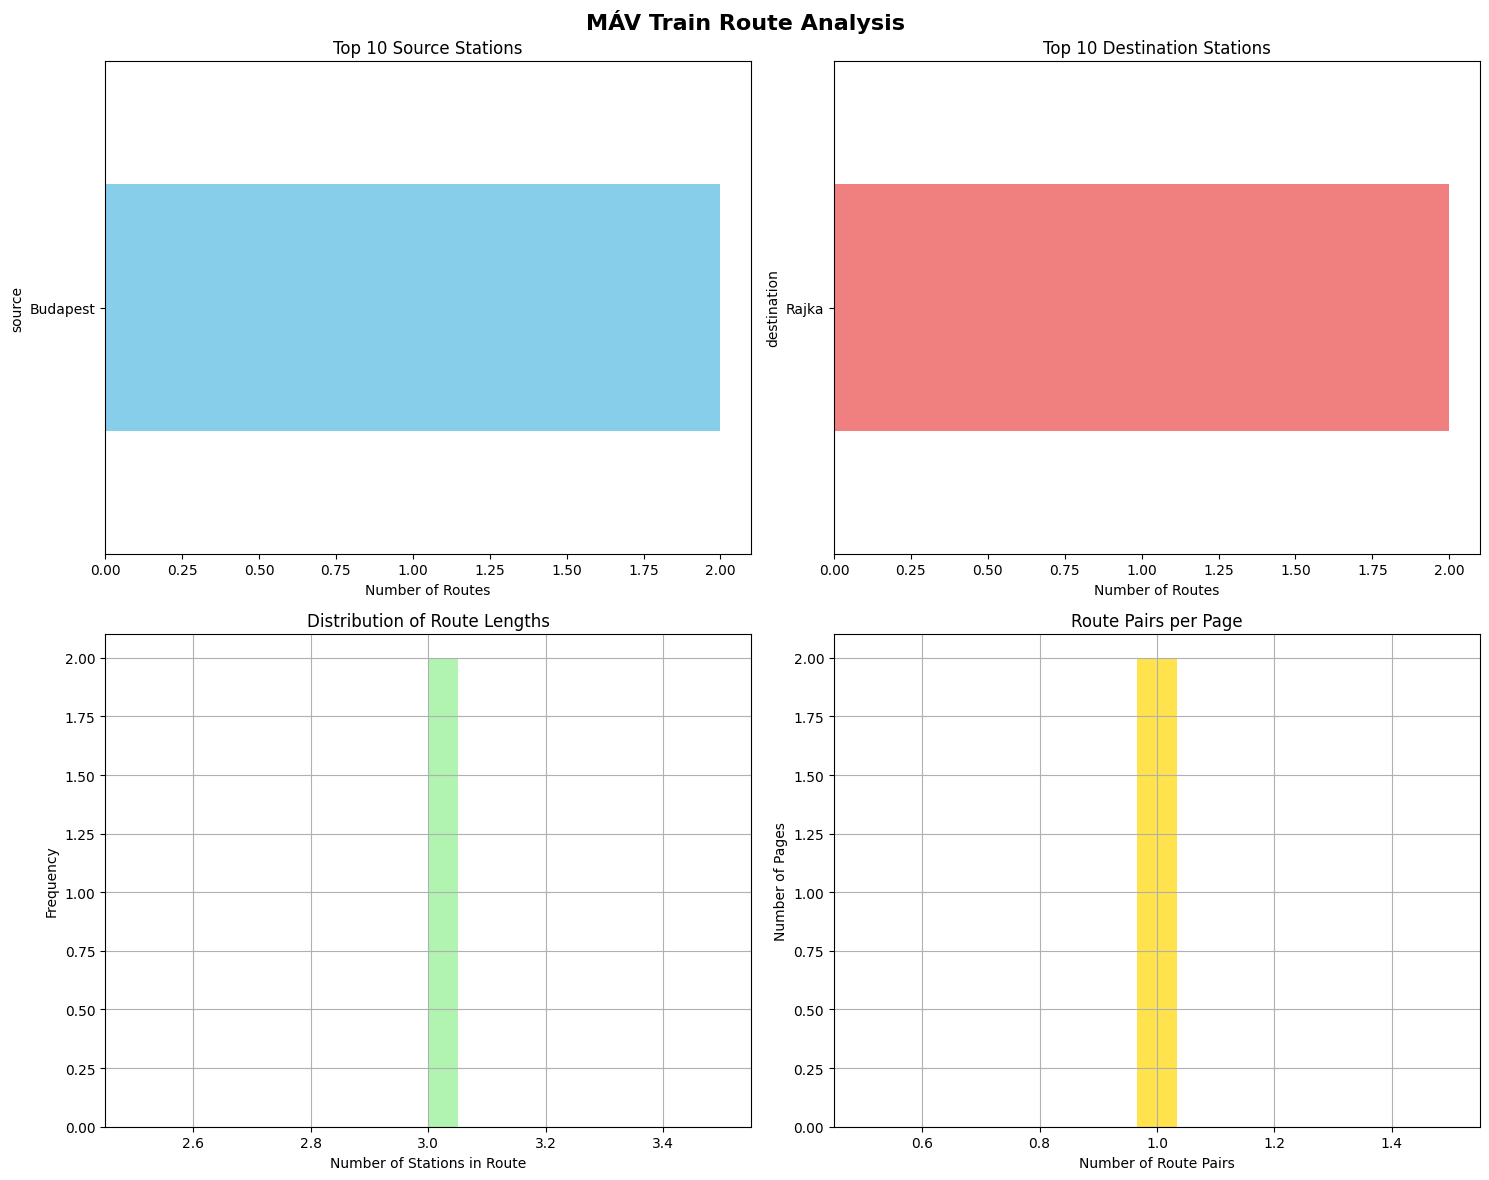

📊 Visualizations created successfully!


In [32]:
def analyze_route_data(routes):
    """
    Analyze the extracted route data and create visualizations.
    
    Args:
        routes: List of route dictionaries
    
    Returns:
        dict: Analysis results
    """
    
    if not routes:
        print("❌ No data to analyze")
        return {}
    
    print(f"\n📈 ANALYZING {len(routes)} ROUTES")
    print("="*40)
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(routes)
    
    # Basic statistics
    total_routes = len(df)
    unique_pairs = len(df.drop_duplicates(['source', 'destination']))
    unique_sources = df['source'].nunique()
    unique_destinations = df['destination'].nunique()
    pages_with_data = df['page'].nunique()
    
    print(f"📊 SUMMARY STATISTICS:")
    print(f"   - Total routes: {total_routes}")
    print(f"   - Unique station pairs: {unique_pairs}")
    print(f"   - Unique source stations: {unique_sources}")
    print(f"   - Unique destination stations: {unique_destinations}")
    print(f"   - Pages with data: {pages_with_data}")
    print(f"   - Average stations per route: {df['total_stations'].mean():.1f}")
    
    # Top stations
    print(f"\n🚉 TOP 10 SOURCE STATIONS:")
    top_sources = df['source'].value_counts().head(10)
    for i, (station, count) in enumerate(top_sources.items(), 1):
        print(f"   {i:2d}. {station}: {count} routes")
    
    print(f"\n🎯 TOP 10 DESTINATION STATIONS:")
    top_destinations = df['destination'].value_counts().head(10)
    for i, (station, count) in enumerate(top_destinations.items(), 1):
        print(f"   {i:2d}. {station}: {count} routes")
    
    # Route length distribution
    print(f"\n🚂 ROUTE LENGTH DISTRIBUTION:")
    length_dist = df['total_stations'].value_counts().sort_index()
    for stations, count in length_dist.head(10).items():
        print(f"   {stations} stations: {count} routes")
    
    # Create visualizations
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('MÁV Train Route Analysis', fontsize=16, fontweight='bold')
        
        # 1. Top source stations
        top_sources.head(10).plot(kind='barh', ax=axes[0,0], color='skyblue')
        axes[0,0].set_title('Top 10 Source Stations')
        axes[0,0].set_xlabel('Number of Routes')
        
        # 2. Top destination stations
        top_destinations.head(10).plot(kind='barh', ax=axes[0,1], color='lightcoral')
        axes[0,1].set_title('Top 10 Destination Stations')
        axes[0,1].set_xlabel('Number of Routes')
        
        # 3. Route length distribution
        df['total_stations'].hist(bins=20, ax=axes[1,0], color='lightgreen', alpha=0.7)
        axes[1,0].set_title('Distribution of Route Lengths')
        axes[1,0].set_xlabel('Number of Stations in Route')
        axes[1,0].set_ylabel('Frequency')
        
        # 4. Routes per page
        routes_per_page = df.groupby('page').size()
        routes_per_page.hist(bins=15, ax=axes[1,1], color='gold', alpha=0.7)
        axes[1,1].set_title('Route Pairs per Page')
        axes[1,1].set_xlabel('Number of Route Pairs')
        axes[1,1].set_ylabel('Number of Pages')
        
        plt.tight_layout()
        plt.show()
        
        print(f"📊 Visualizations created successfully!")
    
    except Exception as e:
        print(f"⚠️  Could not create visualizations: {e}")
    
    return {
        'total_routes': total_routes,
        'unique_pairs': unique_pairs,
        'unique_sources': unique_sources,
        'unique_destinations': unique_destinations,
        'pages_with_data': pages_with_data,
        'top_sources': top_sources.to_dict(),
        'top_destinations': top_destinations.to_dict(),
        'dataframe': df
    }

# Analyze the route data
analysis_result = analyze_route_data(full_routes)


In [33]:
def extract_budapest_rajka_pairs(routes):
    """
    Extract and analyze Budapest ↔ Rajka route pairs specifically.
    
    Args:
        routes: List of route dictionaries
    
    Returns:
        dict: Budapest-Rajka analysis results
    """
    
    print("\n🎯 EXTRACTING BUDAPEST ↔ RAJKA UNIQUE PAIRS")
    print("="*50)
    
    if not routes:
        print("❌ No route data available")
        return {}
    
    # Filter for Budapest-Rajka routes
    budapest_rajka_routes = []
    
    for route in routes:
        route_header = route['route_header'].lower()
        source = route['source'].lower()
        destination = route['destination'].lower()
        
        # Check if route involves Budapest and (Rajka or Hegyeshalom)
        involves_budapest = 'budapest' in route_header or 'budapest' in source or 'budapest' in destination
        involves_border = ('rajka' in route_header or 'hegyeshalom' in route_header or 
                          'rajka' in source or 'rajka' in destination or
                          'hegyeshalom' in source or 'hegyeshalom' in destination)
        
        if involves_budapest and involves_border:
            budapest_rajka_routes.append(route)
    
    print(f"📋 Found {len(budapest_rajka_routes)} Budapest-Rajka related routes")
    
    if not budapest_rajka_routes:
        print("❌ No Budapest-Rajka routes found")
        return {}
    
    # Group by unique direction pairs
    unique_directions = {}
    
    for route in budapest_rajka_routes:
        source = route['source']
        destination = route['destination']
        direction_key = f"{source} → {destination}"
        
        if direction_key not in unique_directions:
            unique_directions[direction_key] = {
                'source': source,
                'destination': destination,
                'count': 1,
                'sample_route': route['route_header'],
                'pages': [route['page']],
                'station_counts': [route['total_stations']]
            }
        else:
            unique_directions[direction_key]['count'] += 1
            unique_directions[direction_key]['pages'].append(route['page'])
            unique_directions[direction_key]['station_counts'].append(route['total_stations'])
    
    print(f"\n🚂 UNIQUE BUDAPEST ↔ RAJKA DIRECTIONS:")
    print("="*50)
    
    # Sort by source station for better organization
    sorted_directions = sorted(unique_directions.items(), key=lambda x: x[1]['source'])
    
    for i, (direction, info) in enumerate(sorted_directions, 1):
        print(f"{i:2d}. {info['source']} → {info['destination']}")
        print(f"    📊 Found in {info['count']} route instance(s)")
        print(f"    📄 Pages: {info['pages'][:5]}{'...' if len(info['pages']) > 5 else ''}")
        print(f"    🔗 Sample: {info['sample_route']}")
        print(f"    📏 Stations: {info['station_counts'][:3]}{'...' if len(info['station_counts']) > 3 else ''}")
        print()
    
    # Analyze directional patterns
    budapest_to_border = []
    border_to_budapest = []
    
    for direction, info in unique_directions.items():
        source_lower = info['source'].lower()
        dest_lower = info['destination'].lower()
        
        if 'budapest' in source_lower and ('rajka' in dest_lower or 'hegyeshalom' in dest_lower):
            budapest_to_border.append(info)
        elif ('rajka' in source_lower or 'hegyeshalom' in source_lower) and 'budapest' in dest_lower:
            border_to_budapest.append(info)
    
    print(f"🔄 DIRECTIONAL ANALYSIS:")
    print(f"   - Budapest → Border: {len(budapest_to_border)} unique directions")
    for route in budapest_to_border:
        print(f"     • {route['source']} → {route['destination']} ({route['count']} instances)")
    
    print(f"   - Border → Budapest: {len(border_to_budapest)} unique directions")
    for route in border_to_budapest:
        print(f"     • {route['source']} → {route['destination']} ({route['count']} instances)")
    
    # Create summary
    summary = {
        'total_routes': len(budapest_rajka_routes),
        'unique_directions': len(unique_directions),
        'budapest_to_border': len(budapest_to_border),
        'border_to_budapest': len(border_to_budapest),
        'directions': unique_directions,
        'routes': budapest_rajka_routes
    }
    
    print(f"\n📊 BUDAPEST-RAJKA SUMMARY:")
    print(f"   - Total route instances: {summary['total_routes']}")
    print(f"   - Unique directions: {summary['unique_directions']}")
    print(f"   - Budapest → Border: {summary['budapest_to_border']}")
    print(f"   - Border → Budapest: {summary['border_to_budapest']}")
    
    return summary

# Extract Budapest-Rajka pairs
budapest_rajka_result = extract_budapest_rajka_pairs(full_routes)



🎯 EXTRACTING BUDAPEST ↔ RAJKA UNIQUE PAIRS
📋 Found 2 Budapest-Rajka related routes

🚂 UNIQUE BUDAPEST ↔ RAJKA DIRECTIONS:
 1. Budapest → Rajka
    📊 Found in 2 route instance(s)
    📄 Pages: [2, 4]
    🔗 Sample: 1 Budapest — Hegyeshalom — Rajka
    📏 Stations: [3, 3]

🔄 DIRECTIONAL ANALYSIS:
   - Budapest → Border: 1 unique directions
     • Budapest → Rajka (2 instances)
   - Border → Budapest: 0 unique directions

📊 BUDAPEST-RAJKA SUMMARY:
   - Total route instances: 2
   - Unique directions: 1
   - Budapest → Border: 1
   - Border → Budapest: 0


In [34]:
def export_results_to_csv(routes, analysis_result, budapest_rajka_result):
    """
    Export all extraction results to CSV files.
    
    Args:
        routes: List of all route dictionaries
        analysis_result: Analysis results dictionary
        budapest_rajka_result: Budapest-Rajka specific results
    
    Returns:
        dict: Information about exported files
    """
    
    print("\n💾 EXPORTING RESULTS TO CSV FILES")
    print("="*40)
    
    if not routes:
        print("❌ No data to export")
        return {}
    
    # Create timestamp for file naming
    timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    exported_files = {}
    
    try:
        # 1. Export all routes with full details
        df_all = pd.DataFrame(routes)
        filename_all = f"mav_all_routes_{timestamp}.csv"
        df_all.to_csv(filename_all, index=False, encoding='utf-8')
        exported_files['all_routes'] = filename_all
        print(f"✅ All routes exported: {filename_all} ({len(df_all)} routes)")
        
        # 2. Export unique station pairs only
        df_unique = df_all.drop_duplicates(['source', 'destination'])[['source', 'destination', 'total_stations', 'route_header']]
        filename_unique = f"mav_unique_pairs_{timestamp}.csv"
        df_unique.to_csv(filename_unique, index=False, encoding='utf-8')
        exported_files['unique_pairs'] = filename_unique
        print(f"✅ Unique pairs exported: {filename_unique} ({len(df_unique)} pairs)")
        
        # 3. Export station frequency analysis
        if 'top_sources' in analysis_result and 'top_destinations' in analysis_result:
            # Combine source and destination frequencies
            all_stations = {}
            
            # Add source frequencies
            for station, count in analysis_result['top_sources'].items():
                all_stations[station] = all_stations.get(station, 0) + count
            
            # Add destination frequencies  
            for station, count in analysis_result['top_destinations'].items():
                all_stations[station] = all_stations.get(station, 0) + count
            
            df_freq = pd.DataFrame([
                {'station': station, 'total_appearances': count}
                for station, count in sorted(all_stations.items(), key=lambda x: x[1], reverse=True)
            ])
            
            filename_freq = f"mav_station_frequency_{timestamp}.csv"
            df_freq.to_csv(filename_freq, index=False, encoding='utf-8')
            exported_files['station_frequency'] = filename_freq
            print(f"✅ Station frequency exported: {filename_freq} ({len(df_freq)} stations)")
        
        # 4. Export Budapest-Rajka specific results
        if budapest_rajka_result and 'directions' in budapest_rajka_result:
            budapest_data = []
            for direction, info in budapest_rajka_result['directions'].items():
                budapest_data.append({
                    'direction': direction,
                    'source': info['source'],
                    'destination': info['destination'],
                    'route_count': info['count'],
                    'sample_route_header': info['sample_route'],
                    'pages': ', '.join(map(str, info['pages'][:10])),  # First 10 pages
                    'avg_stations': sum(info['station_counts']) / len(info['station_counts']) if info['station_counts'] else 0
                })
            
            if budapest_data:
                df_budapest = pd.DataFrame(budapest_data)
                filename_budapest = f"budapest_rajka_pairs_{timestamp}.csv"
                df_budapest.to_csv(filename_budapest, index=False, encoding='utf-8')
                exported_files['budapest_rajka'] = filename_budapest
                print(f"✅ Budapest-Rajka pairs exported: {filename_budapest} ({len(df_budapest)} directions)")
        
        # 5. Export summary statistics
        summary_data = {
            'extraction_timestamp': timestamp,
            'total_routes': len(routes),
            'unique_pairs': analysis_result.get('unique_pairs', 0),
            'unique_sources': analysis_result.get('unique_sources', 0),
            'unique_destinations': analysis_result.get('unique_destinations', 0),
            'pages_processed': 724 if len(routes) > 100 else 5,  # Estimate based on data size
            'budapest_rajka_routes': budapest_rajka_result.get('total_routes', 0),
            'budapest_rajka_directions': budapest_rajka_result.get('unique_directions', 0)
        }
        
        df_summary = pd.DataFrame([summary_data])
        filename_summary = f"mav_extraction_summary_{timestamp}.csv"
        df_summary.to_csv(filename_summary, index=False, encoding='utf-8')
        exported_files['summary'] = filename_summary
        print(f"✅ Summary exported: {filename_summary}")
        
        print(f"\n🎉 EXPORT COMPLETE!")
        print(f"   📂 Files created: {len(exported_files)}")
        print(f"   🏷️  Timestamp: {timestamp}")
        
        return {
            'success': True,
            'timestamp': timestamp,
            'files': exported_files,
            'total_files': len(exported_files)
        }\n        \n    except Exception as e:\n        print(f\"❌ Export failed: {e}\")\n        return {'success': False, 'error': str(e)}\n\n# Export all results\nif full_routes:\n    export_result = export_results_to_csv(full_routes, analysis_result, budapest_rajka_result)\nelse:\n    print(\"⚠️  No data available for export\")\n    export_result = {'success': False, 'error': 'No data'}"


SyntaxError: unexpected character after line continuation character (3941400559.py, line 111)